# **Denoising Diffusion Probabilistic Models**

This notebook is going to contain code for all the components needed. For an explanation of the math, please refer to the excellent [blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) by Lilian Weng.

The structure is going to be intuition of the working followed by blocks of code of all the components needed. Refer to the original paper [here](https://arxiv.org/abs/2006.11239).


The crux of the working is that we use a UNet model to predict the amount of noise in a noisy image. The noise is added to the images using a scheduler where each timestep denotes how much noise to add to the image. You send in the noisy image with timestep encoded and the UNet predicts the noise. The loss is between the real noise and the generated noise. During inference, we simply need to subtract this predicted noise from the input, so to speak, to get a meaningful image.

In [1]:
import torch.nn as nn
import torch
import numpy
import math
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### UNet

The original UNet model paper can be found [here](https://arxiv.org/abs/1505.04597). For DDPM, we change the original structure by adding timestep embeddings and architectural changes like adding attention. I've skipped the attention layer implementation in this implementation but the comments will show where the attention block should've come.

In [2]:
## Downsample step that downsamples feature maps by 2 in the left path of the UNet
## a design choice is choosing maxpooling or a convolutional layer with stride 2 to do the downsampling - on one hand
## a convolutional layer has weights that can learn important features while downsampling but it is also slightly more
## computationally expensive. Maxpooling adds non-linearity to the model but it is a fixed function so no learning but
## no weights mean it is cheaper. I've chosen maxpooling because of computation.

class DownSample(nn.Module):
  def __init__(self):
    super().__init__()
    self.down = nn.MaxPool2d(2)

  def forward(self, x: torch.Tensor, t: torch.Tensor): # t is the timestep embedding which we include in the forward here to make it uniform so the class can be used in a ModuleList
    return self.down(x)

In [3]:
## Upsample step that upsamples feature maps by 2 in the right path of the UNet

class UpSample(nn.Module):
  def __init__(self, in_channels: int):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels, (4,4), (2,2), (1,1))

  def forward(self, x: torch.Tensor, t: torch.Tensor): # t is the timestep embedding which we include in the forward here to make it uniform so the class can be used in a ModuleList
    return self.up(x)

In [4]:
## Timestep embedding which is done in a similar way to the positional encodings used in Transformers and then transformed through linear layers

class TimeStepEncoder(nn.Module):
  def __init__(self, embed_dim: int):
    super().__init__()
    self.dim = embed_dim

    self.layer1 = nn.Linear(self.dim//4, self.dim)
    self.layer2 = nn.Linear(self.dim, self.dim)
    self.swish = nn.SiLU()

  def forward(self, x: torch.Tensor):

    # positional encoding
    emb = math.log(10000) / (self.dim // 8 - 1)
    emb = torch.exp(torch.arange(self.dim // 8, device=x.device) * -emb)
    emb = x[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=1)

    # transformation
    emb = self.layer2(self.swish(self.layer1(emb)))

    return emb

In [5]:
## Unet blocks which is one feature level in the left & right paths of the UNet made of residual block structure
## In the original paper, the block was residual block followed by attention
## The main difference between the left and right paths is that for the right path, the in channels will actually be in_ch+out_ch due to the residual connections between the two paths

class UBlock(nn.Module):
  def __init__(self, in_ch: int, out_ch: int, embed_dim: int, n_g: int = 16, dropout: float = 0.1):
    super().__init__()

    self.groupnorm1 = nn.GroupNorm(n_g, in_ch)
    self.swish1 = nn.SiLU()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1)

    self.linear = nn.Linear(embed_dim,out_ch)
    self.swish2 = nn.SiLU()

    self.groupnorm2 = nn.GroupNorm(n_g, out_ch)
    self.swish3 = nn.SiLU()
    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

    self.dropout = nn.Dropout(dropout)

    if in_ch == out_ch:
      self.res_connection = nn.Identity()
    else:
      self.res_connection = nn.Conv2d(in_ch, out_ch, kernel_size = 1)

  def forward(self, x: torch.Tensor, t: torch.Tensor):

    k = self.conv1(self.swish1(self.groupnorm1(x)))

    t = self.swish2(self.linear(t))

    # concat the timestep embedding
    k +=  t[:,:,None, None]

    k = self.conv2(self.dropout(self.swish3(self.groupnorm2(k))))

    k += self.res_connection(x)

    return k

In [6]:
## combine all the blocks for the unified UNet architecture

class UNet(nn.Module):

  def __init__(self, ip_ch: int = 3, num_ch: int = 64, res: list = [1,2,2,4]):
    super().__init__()

    self.t_encoder = TimeStepEncoder(num_ch*4)
    self.img_transform = nn.Conv2d(ip_ch, num_ch, kernel_size=3, padding=1)

    in_ch = num_ch

    left = []
    for i in range(len(res)):
      out_ch = in_ch*res[i]
      # print(in_ch, out_ch)
      left.append(UBlock(in_ch, out_ch, num_ch*4))

      in_ch = out_ch

      if i < (len(res)-1):
        left.append(DownSample())

    self.left_unet = nn.ModuleList(left)

    self.lowest = UBlock(in_ch, in_ch,num_ch*4)

    in_ch = out_ch

    right = []
    for i in reversed(range(len(res))):
      out_ch = in_ch

      right.append(UBlock(in_ch+out_ch, out_ch, num_ch * 4))

      out_ch = in_ch // res[i]
      # print(in_ch, out_ch)
      # print(in_ch+out_ch)
      right.append(UBlock(in_ch+out_ch, out_ch, num_ch * 4))

      in_ch = out_ch

      if i > 0:
        right.append(UpSample(in_ch))

    self.right_unet = nn.ModuleList(right)

    self.norm = nn.GroupNorm(8, num_ch)
    self.act = nn.SiLU()
    self.final = nn.Conv2d(in_ch, ip_ch, kernel_size=3, padding=1)

  def forward(self, x: torch.Tensor, t: torch.Tensor):

    x = self.img_transform(x)
    t = self.t_encoder(t)

    ip_list = [x]

    for layer in self.left_unet:
      # print(x.shape)
      x = layer(x,t)
      ip_list.append(x)

    x = self.lowest(x,t)

    for layer in self.right_unet:
      if isinstance(layer,UpSample):
        x = layer(x,t)
      else:
        x_cat = ip_list.pop()

        x = torch.cat((x,x_cat), dim=1)

        x = layer(x,t)

    x = self.final(self.act(self.norm(x)))

    return x

### Putting together final model

The variables like beta, alpha, alpha_bar are calculated exactly like how the equations are in the paper and the q_sample and p_sample steps re also just python implementations of the equations.

In [7]:
class DDPM(nn.Module):
  def __init__(self, unet, steps: int, device: torch.device, beta_min: int = 0.0001, beta_max: int = 0.02):
    super().__init__()

    self.unet = unet

    # fixed linear variance schedule
    self.beta = torch.linspace(beta_min, beta_max, steps).to(device)

    self.alpha = 1 - self.beta

    self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    self.steps = steps

    self.sigma_square = self.beta

  def q_sample(self, x_0: torch.Tensor, t: torch.Tensor, eps = None):
    if eps is None:
      eps = torch.randn_like(x_0)

    temp = self.alpha_bar.gather(-1,t).reshape(-1,1,1,1)
    mean = temp**0.5 * x_0

    var = 1 - temp

    x_t = mean + var**0.5 * eps

    return x_t

  def p_sample(self, x_t: torch.Tensor, t: torch.Tensor):

    noise_learned = self.unet(x_t, t)
    alpha_bar = self.alpha_bar.gather(-1,t).reshape(-1,1,1,1)
    alpha = self.alpha.gather(-1,t).reshape(-1,1,1,1)
    noise_coef = (1 - alpha) / (1 - alpha_bar) ** 0.5
    mean = 1 / (alpha ** 0.5) * (x_t - noise_coef * noise_learned)
    var = self.sigma_square.gather(-1,t).reshape(-1,1,1,1)

    noise = torch.randn_like(x_t)

    p_t = mean + var**0.5 * noise

    return p_t

  def loss(self, x_0: torch.Tensor, noise=None):
    b_s = x_0.shape[0]

    t = torch.randint(0,self.steps, (b_s,), device=x_0.device)

    if noise is None:
      noise = torch.randn_like(x_0)

    x_t = self.q_sample(x_0,t,noise)

    noise_learned = self.unet(x_t,t)

    loss = torch.nn.functional.mse_loss(noise, noise_learned)

    return loss

### Training Script

In [37]:
epochs = 20
steps = 300
batch_size = 4
img_size = 32
img_ch = 1
lr = 0.00002
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [9]:
print(device)

cuda


In [38]:
transform = transforms.Compose((transforms.RandomHorizontalFlip(), transforms.Resize(img_size), transforms.ToTensor(), transforms.Lambda(lambda t: (t * 2) - 1)))
trainset = datasets.FashionMNIST('~/pytorch/F_MNIST_data', download=True,train=True,transform=transform)
# testset = datasets.FashionMNIST('~/pytorch/F_MNIST_data', download=True,train=False,transform=transforms.ToTensor())

In [39]:
## overfit on 500 samples for sanity check, faster training
import random
tset = torch.utils.data.Subset(trainset, random.sample(range(1,60000),1000))

In [40]:
trainloader = torch.utils.data.DataLoader(tset, batch_size=batch_size, shuffle=True)

In [41]:
len(trainset), len(tset)

(60000, 1000)

In [42]:
unet = UNet(ip_ch=img_ch).to(device)

In [43]:
ddpm_model = DDPM(unet=unet,steps=steps,device=device)

In [44]:
optimizer = optim.Adam(unet.parameters(), lr=lr)

In [51]:
def plot_img(img,epoch):
  # img = (img + 1) / 2
  img = img.cpu().numpy()
  # print(img.max(), img.min())
  fig, axs = plt.subplots(1, img.shape[0], figsize=(200,200))

  for i in range(img.shape[0]):
    ax = axs[i]
    ax.imshow(img[i][0],cmap='gray')
  plt.title("Generation at epoch "+str(epoch))

In [46]:
final_loss = []

for epoch in range(epochs):
  train_loss = []
  for i, (img,tgt) in enumerate(trainloader):
    img = img.to(device)

    optimizer.zero_grad()

    loss = ddpm_model.loss(img)

    loss.backward()

    optimizer.step()
    train_loss.append(loss.item())
  final_loss.append(sum(train_loss)/len(train_loss))
  print('Epoch done '+str(epoch))

Epoch done 0
Epoch done 1
Epoch done 2
Epoch done 3
Epoch done 4
Epoch done 5
Epoch done 6
Epoch done 7
Epoch done 8
Epoch done 9
Epoch done 10
Epoch done 11
Epoch done 12
Epoch done 13
Epoch done 14
Epoch done 15
Epoch done 16
Epoch done 17
Epoch done 18
Epoch done 19


Text(0.5, 1.0, 'Training Loss Curve')

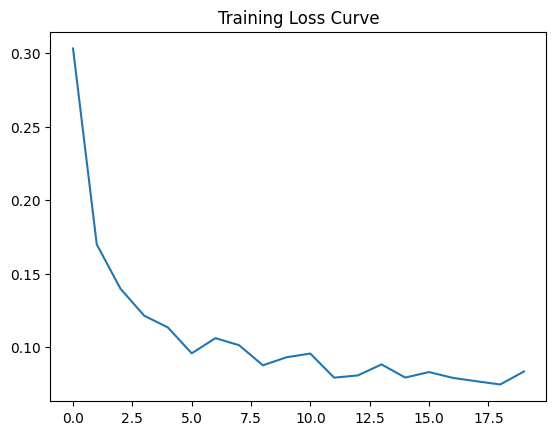

In [47]:
plt.plot(final_loss)
plt.title('Training Loss Curve')

In [52]:
## Random generation after training
num_samples = 4
with torch.no_grad():
    x = torch.randn([num_samples, img_ch, img_size, img_size], device=device)

    for j in range(steps):
      t = steps - j - 1

      x = ddpm_model.p_sample(x, x.new_full((num_samples,), t, dtype=torch.int64))

    plot_img(x,epoch)